In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

In [ ]:
# Loading the dataset (Cleveland Heart Disease Dataset)
def load_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
    df = pd.read_csv(url, names=columns, na_values='?')
    df.dropna(inplace=True)
    print("Data Loaded Successfully.")
    return df

In [22]:
df = load_data()

Data Loaded Successfully.


In [23]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [24]:
df.shape

(297, 14)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  target    297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB


In [26]:
df.duplicated().sum()

0

In [27]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
# Normalization
def normalize_data(df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df.drop(columns=["target"]))
    return normalized_data

In [ ]:
#ECDO Hybrid Algorithm (DSOA + EFO)
def ecdo_algorithm(data, iterations=50, population_size=10):
    results = []
    n, d = data.shape  #(297, 14  => no of records, fields)

    # Initializing the population randomly
    population = np.random.rand(population_size, d)

    original_mean = np.mean(data, axis=0)  # original mean  is calculated for comparision and calculation

    best_solution = population[0].copy()
    best_fitness = float('inf')

    for i in range(iterations):
        # DSOA Phase - Echolocation Update
        new_solutions = population + np.random.rand(population_size, 1) * (best_solution - population)

        # Calculating fitness through original_mean
        fitness_values = 0.5 * np.mean(np.abs(new_solutions - original_mean), axis=1) + 0.5 * np.mean((new_solutions - original_mean) ** 2, axis=1)

        # Updating the best solution if fitness improves
        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < best_fitness:
            best_fitness = fitness_values[min_idx]
            best_solution = new_solutions[min_idx].copy()

        # EFO Phase - Electric Field Update
        new_solutions = population + np.random.rand(population_size, 1) * (best_solution - population)

        # fitness update
        fitness_values = 0.5 * np.mean(np.abs(new_solutions - original_mean), axis=1) + 0.5 * np.mean((new_solutions - original_mean) ** 2, axis=1)

        # best solution update
        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < best_fitness:
            best_fitness = fitness_values[min_idx]
            best_solution = new_solutions[min_idx].copy()

        # Hybridizing 
        population = 0.5 * (population + new_solutions[min_idx])

        # parameter calculationg at every 10 iteration
        if i % 10 == 0:
            kca = np.mean(np.abs(best_solution - original_mean)) 
            key_sensitivity = np.std(best_solution)  
            privacy = 1 - kca  
            dpr = np.sum(best_solution > 0.5) / d  
            cca = kca  #  (same as KCA)

            # Fitness Objective Triad
            concealing_ratio = np.mean(np.abs(best_solution - original_mean) > 0.1)  
            secrecy = key_sensitivity / (np.std(original_mean) + 1e-6)  
            data_conservation_percentage = 100 - (concealing_ratio * 100)

            results.append([i, kca, key_sensitivity, privacy, dpr, cca, best_fitness,
                            concealing_ratio, secrecy, data_conservation_percentage])

    # Restoration Accuracy & MSE
    restoration_accuracy = 1 - np.mean(np.abs(best_solution - original_mean))
    restoration_mse = np.mean((best_solution - original_mean) ** 2)

    print("Final Restoration Accuracy:", restoration_accuracy)
    print("Final Restoration MSE:", restoration_mse)

    return np.array(results)

In [ ]:
def dsoa_algorithm(data, iterations=50):
    results = []
    n, d = data.shape 
    population_size = 10
    population = np.random.rand(population_size, d)
    best_solution = population[0].copy()
    best_fitness = float('inf')

    # Store original data's mean as a reference 
    original_mean = np.mean(data, axis=0)

    for i in range(iterations):
        for j in range(population_size):
            # Echolocation update (sanitization phase)
            new_solution = population[j] + np.random.rand() * (best_solution - population[j])
            fitness = np.sum(new_solution) 
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = new_solution.copy()

        if i % 10 == 0:
            # Calculate metrics using original_mean as a proxy for restoration reference
            kca = np.mean(np.abs(best_solution - original_mean))  
            key_sensitivity = np.std(best_solution)
            privacy = 1 - np.mean(np.abs(best_solution - original_mean))
            dpr = np.sum(best_solution > 0.5) / d  
            cca = kca  
            fitness_val = best_fitness

            # Fitness Objective Triad:
            concealing_ratio = np.sum(np.abs(best_solution - original_mean) > 0.1) / d
            secrecy = np.std(best_solution) / (np.std(original_mean) + 1e-6)  
            data_conservation_percentage = 100 - (concealing_ratio * 100)

            results.append([i, kca, key_sensitivity, privacy, dpr, cca, fitness_val,
                            concealing_ratio, secrecy, data_conservation_percentage])
    return np.array(results)

In [ ]:
def efo_algorithm(data, iterations=50):
    results = []
    n, d = data.shape  
    population_size = 10
    population = np.random.rand(population_size, d)
    best_solution = population[0].copy()
    best_fitness = float('inf')

    # Store original data's mean as a reference (simulating a restoration baseline)
    original_mean = np.mean(data, axis=0)

    for i in range(iterations):
        for j in range(population_size):
            # Electric field update (sanitization phase)
            new_solution = population[j] + np.random.rand() * (best_solution - population[j])
            fitness = np.sum(new_solution)  
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = new_solution.copy()

        if i % 10 == 0:
            # Calculate metrics using original_mean as a proxy for restoration reference
            kca = np.mean(np.abs(best_solution - original_mean))  
            key_sensitivity = np.std(best_solution)
            privacy = 1 - np.mean(np.abs(best_solution - original_mean))
            dpr = np.sum(best_solution > 0.5) / d  
            cca = kca  
            fitness_val = best_fitness

            # Fitness Objective Triad:
            concealing_ratio = np.sum(np.abs(best_solution - original_mean) > 0.1) / d
            secrecy = np.std(best_solution) / (np.std(original_mean) + 1e-6)
            data_conservation_percentage = 100 - (concealing_ratio * 100)

            results.append([i, kca, key_sensitivity, privacy, dpr, cca, fitness_val,
                            concealing_ratio, secrecy, data_conservation_percentage])
    return np.array(results)

In [ ]:
def smo_algorithm(data, iterations=50):
    results = []
    n, d = data.shape  
    population_size = 10
    population = np.random.rand(population_size, d)
    best_solution = population[0].copy()
    best_fitness = float('inf')

    # Store original data's mean as a reference (simulating a restoration baseline)
    original_mean = np.mean(data, axis=0)

    for i in range(iterations):
        for j in range(population_size):
            # Social mimic update (sanitization phase)
            neighbor = population[np.random.randint(0, population_size)]
            new_solution = population[j] + np.random.rand() * (neighbor - population[j])
            fitness = np.sum(new_solution)  
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = new_solution.copy()

        if i % 10 == 0:
            # Calculate metrics using original_mean as a proxy for restoration reference
            kca = np.mean(np.abs(best_solution - original_mean))  
            key_sensitivity = np.std(best_solution)
            privacy = 1 - np.mean(np.abs(best_solution - original_mean))
            dpr = np.sum(best_solution > 0.5) / d  
            cca = kca  
            fitness_val = best_fitness

            # Fitness Objective Triad:
            concealing_ratio = np.sum(np.abs(best_solution - original_mean) > 0.1) / d
            secrecy = np.std(best_solution) / (np.std(original_mean) + 1e-6)  
            data_conservation_percentage = 100 - (concealing_ratio * 100)

            results.append([i, kca, key_sensitivity, privacy, dpr, cca, fitness_val,
                            concealing_ratio, secrecy, data_conservation_percentage])
    return np.array(results)

In [ ]:
def j_sso_algorithm(data, iterations=50):
    results = []
    n, d = data.shape  
    population_size = 10
    population = np.random.rand(population_size, d)
    best_solution = population[0].copy()
    best_fitness = float('inf')

    # Store original data's mean as a reference (simulating a restoration baseline)
    original_mean = np.mean(data, axis=0)

    for i in range(iterations):
        for j in range(population_size):
            # Jellyfish movement (random search between best solution and random population member)
            r = np.random.rand()
            if r < 0.5:
                new_solution = population[j] + np.random.rand() * (best_solution - population[j])
            else:
                new_solution = population[j] + np.random.rand() * (population[np.random.randint(0, population_size)] - population[j])

            fitness = np.sum(new_solution)  
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = new_solution.copy()

        # Calculate metrics every 10 iterations
        if i % 10 == 0:
            kca = np.mean(np.abs(best_solution - original_mean))
            key_sensitivity = np.std(best_solution)
            privacy = 1 - np.mean(np.abs(best_solution - original_mean))
            dpr = np.sum(best_solution > 0.5) / d  
            cca = kca  
            fitness_val = best_fitness

            # Fitness Objective Triad:
            concealing_ratio = np.sum(np.abs(best_solution - original_mean) > 0.1) / d
            secrecy = np.std(best_solution) / (np.std(original_mean) + 1e-6)  
            data_conservation_percentage = 100 - (concealing_ratio * 100)

            
            results.append([i, kca, key_sensitivity, privacy, dpr, cca, fitness_val,
                            concealing_ratio, secrecy, data_conservation_percentage])

    return np.array(results)


In [29]:
#loading the normalized data
df = normalize_data(df)

In [ ]:
# Runing the algorithms
ecdo_results = ecdo_algorithm(df)
dsoa_results = dsoa_algorithm(df)
efo_results = efo_algorithm(df)
smo_results = smo_algorithm(df)
j_sso_results = j_sso_algorithm(df)

Final Restoration Accuracy: 0.9043586883232387
Final Restoration MSE: 0.014533888070785364


In [51]:
# Save results to CSV
def save_results(results, filename):
    df = pd.DataFrame(results, columns=["Iteration", "KCA", "Key Sensitivity", "Privacy", "DPR", "CCA", "Fitness",
               "Concealing Ratio", "Secrecy", "Data Conservation Percentage"])
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

In [ ]:
# Saving the results
save_results(ecdo_results, "ecdo_results.csv")
save_results(dsoa_results, "dsoa_results.csv")
save_results(efo_results, "efo_results.csv")
save_results(smo_results, "smo_results.csv")
save_results(j_sso_results, "j_sso_results.csv")

Results saved to ecdo_results.csv
Results saved to dsoa_results.csv
Results saved to efo_results.csv
Results saved to smo_results.csv
Results saved to j_sso_results.csv


In [53]:
ecdo_df = pd.read_csv("ecdo_results.csv")
dsoa_df = pd.read_csv("dsoa_results.csv")
efo_df = pd.read_csv("efo_results.csv")
smo_df = pd.read_csv("smo_results.csv")
j_sso_df = pd.read_csv("j_sso_results.csv")

In [54]:
ecdo_df.head(5)

,Iteration,KCA,Key Sensitivity,Privacy,DPR,CCA,Fitness,Concealing Ratio,Secrecy,Data Conservation Percentage
0,0.0,0.133835,0.182355,0.866165,0.461538,0.133835,0.080882,0.461538,1.006076,53.846154
1,10.0,0.095641,0.159454,0.904359,0.538462,0.095641,0.055088,0.538462,0.879730,46.153846
2,20.0,0.095641,0.159450,0.904359,0.538462,0.095641,0.055088,0.538462,0.879707,46.153846
3,30.0,0.095641,0.159450,0.904359,0.538462,0.095641,0.055088,0.538462,0.879707,46.153846
4,40.0,0.095641,0.159450,0.904359,0.538462,0.095641,0.055088,0.538462,0.879707,46.153846


In [55]:

dsoa_df.head(5)

,Iteration,KCA,Key Sensitivity,Privacy,DPR,CCA,Fitness,Concealing Ratio,Secrecy,Data Conservation Percentage
0,0.0,0.289845,0.231614,0.710155,0.461538,0.289845,5.825109,0.923077,1.277845,7.692308
1,10.0,0.242618,0.248958,0.757382,0.307692,0.242618,5.284922,0.538462,1.373538,46.153846
2,20.0,0.242657,0.249033,0.757343,0.307692,0.242657,5.284913,0.538462,1.373948,46.153846
3,30.0,0.242657,0.249033,0.757343,0.307692,0.242657,5.284913,0.538462,1.373948,46.153846
4,40.0,0.242657,0.249033,0.757343,0.307692,0.242657,5.284913,0.538462,1.373948,46.153846


In [56]:

efo_df.head(5)

,Iteration,KCA,Key Sensitivity,Privacy,DPR,CCA,Fitness,Concealing Ratio,Secrecy,Data Conservation Percentage
0,0.0,0.179130,0.170477,0.820870,0.153846,0.179130,4.249150,0.692308,0.940544,30.769231
1,10.0,0.266639,0.282595,0.733361,0.153846,0.266639,3.242548,0.769231,1.559116,23.076923
2,20.0,0.266647,0.282602,0.733353,0.153846,0.266647,3.242489,0.769231,1.559153,23.076923
3,30.0,0.266647,0.282602,0.733353,0.153846,0.266647,3.242489,0.769231,1.559153,23.076923
4,40.0,0.266647,0.282602,0.733353,0.153846,0.266647,3.242489,0.769231,1.559153,23.076923


In [57]:

smo_df.head(5)

,Iteration,KCA,Key Sensitivity,Privacy,DPR,CCA,Fitness,Concealing Ratio,Secrecy,Data Conservation Percentage
0,0.0,0.216735,0.125620,0.783265,0.307692,0.216735,5.099609,0.846154,0.693061,15.384615
1,10.0,0.188577,0.156931,0.811423,0.076923,0.188577,3.819733,0.538462,0.865812,46.153846
2,20.0,0.188577,0.156931,0.811423,0.076923,0.188577,3.819733,0.538462,0.865812,46.153846
3,30.0,0.188577,0.156931,0.811423,0.076923,0.188577,3.819733,0.538462,0.865812,46.153846
4,40.0,0.188577,0.156931,0.811423,0.076923,0.188577,3.819733,0.538462,0.865812,46.153846


In [58]:

j_sso_df.head(5)

,Iteration,KCA,Key Sensitivity,Privacy,DPR,CCA,Fitness,Concealing Ratio,Secrecy,Data Conservation Percentage
0,0.0,0.174496,0.181420,0.825504,0.230769,0.174496,4.635666,0.692308,1.000917,30.769231
1,10.0,0.239265,0.248831,0.760735,0.230769,0.239265,4.414177,0.692308,1.372836,30.769231
2,20.0,0.240202,0.250019,0.759798,0.230769,0.240202,4.413369,0.769231,1.379391,23.076923
3,30.0,0.240243,0.250072,0.759757,0.230769,0.240243,4.413333,0.769231,1.379684,23.076923
4,40.0,0.240243,0.250072,0.759757,0.230769,0.240243,4.413332,0.769231,1.379684,23.076923


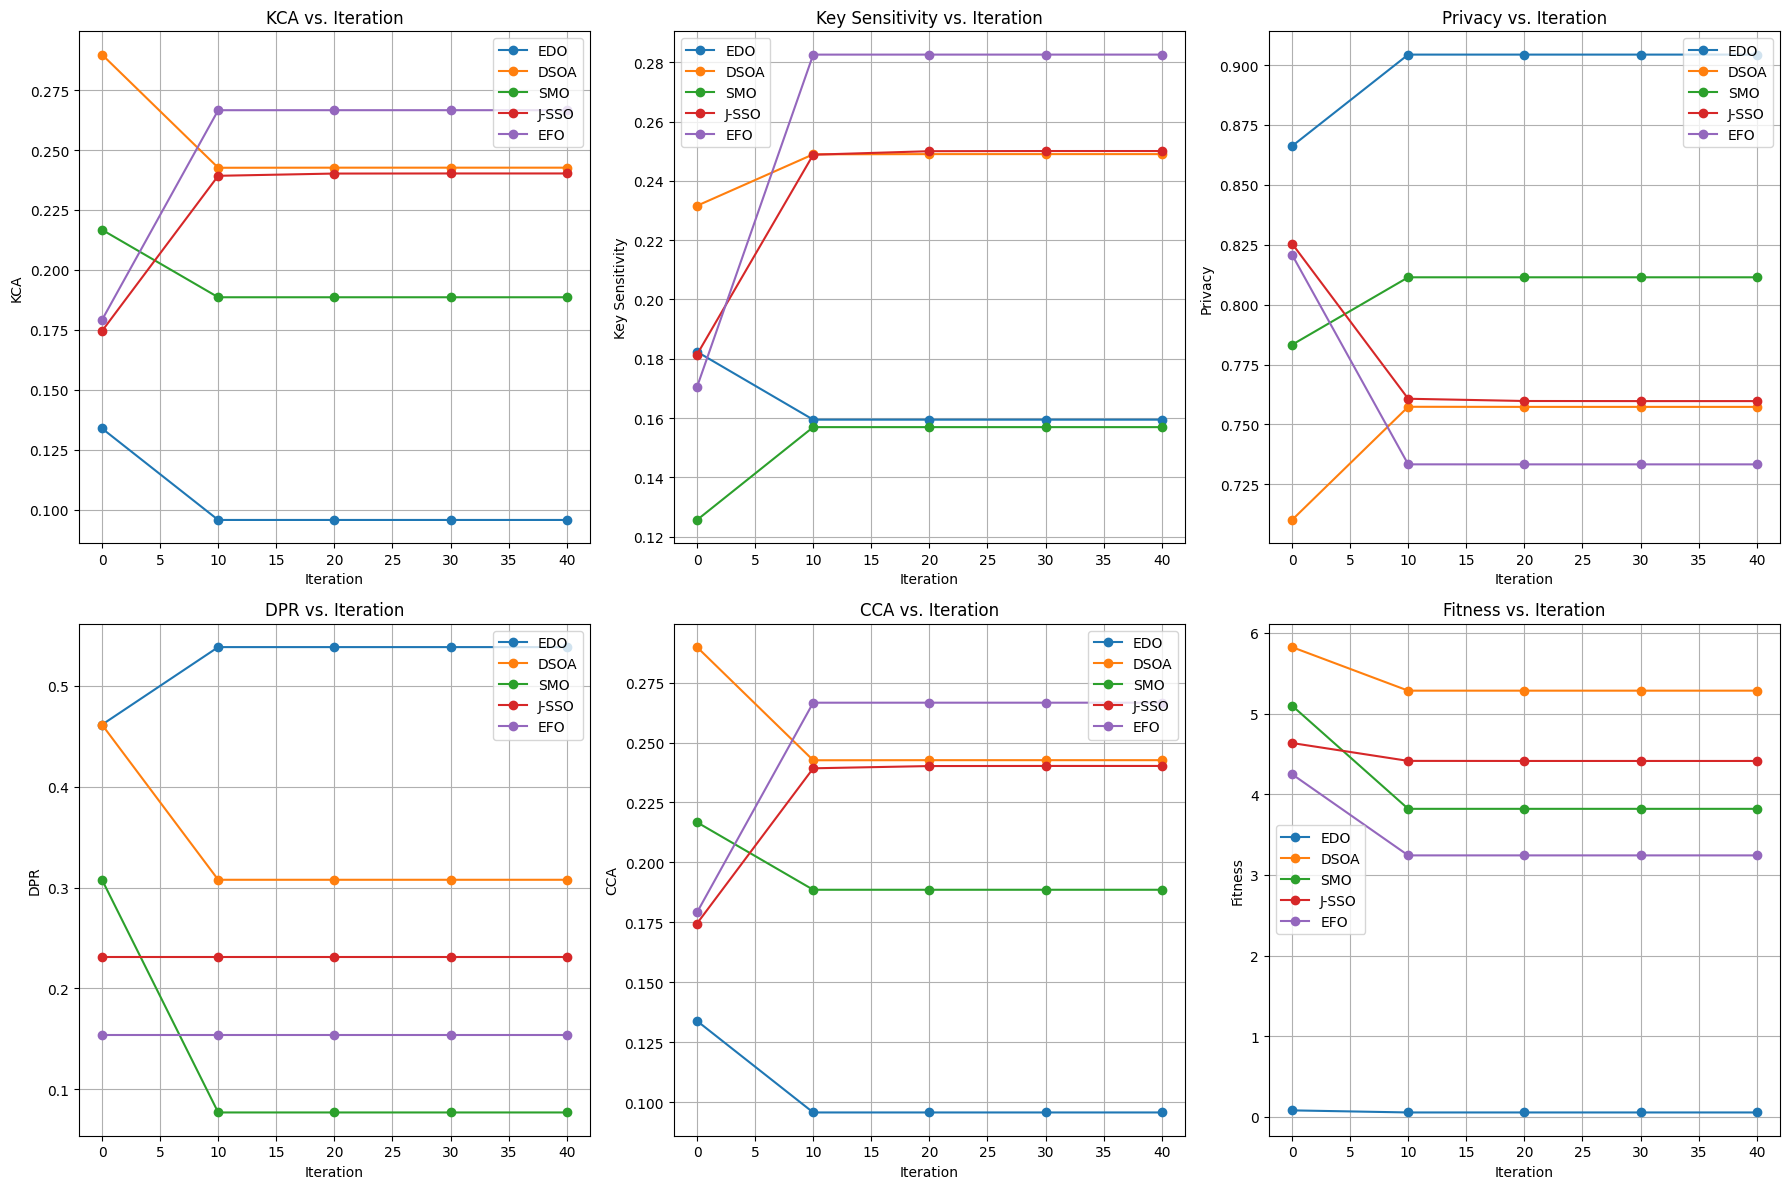

In [ ]:


parameters = ['KCA', 'Key Sensitivity', 'Privacy', 'DPR', 'CCA', 'Fitness']
def plot_comparison(parameter, ax):
    ax.plot(ecdo_df['Iteration'], ecdo_df[parameter], label='EDO', marker='o')
    ax.plot(dsoa_df['Iteration'], dsoa_df[parameter], label='DSOA', marker='o')
    ax.plot(smo_df['Iteration'], smo_df[parameter], label='SMO', marker='o')
    ax.plot(j_sso_df['Iteration'], j_sso_df[parameter], label='J-SSO', marker='o')
    ax.plot(efo_df['Iteration'], efo_df[parameter], label='EFO', marker='o')

    ax.set_xlabel('Iteration')
    ax.set_ylabel(parameter)
    ax.set_title(f'{parameter} vs. Iteration')
    ax.grid(True)
    ax.legend()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, param in enumerate(parameters):
    ax = axes[i // 3, i % 3]  
    plot_comparison(param, ax)


plt.tight_layout()
plt.show()
